### Build TensorFlow Dataset

In [1]:
# !pip uninstall tensorflow -y
# !python3 -m venv .venv
# !source .venv/bin/activate
# !pip install tensorflow==2.15.0
# !pip install pandas pydicom scikit-learn seaborn nbformat

# The cuXXX (CUDA) wheels are Linux-only, NVIDIA GPU-only
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121/

# Use the command from the PyTorch website for macOS!
# !pip install torch torchvision torchaudio

#### Set Parameters

In [2]:
# Set TensorFlow logging level to suppress warnings
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import ast
import pydicom
# from tensorflow.data import AUTOTUNE

#  Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Global configuration
INPUT_SHAPE = (224, 224, 1)  # (512, 512, 1)
TARGET_SIZE = INPUT_SHAPE[:2]

2025-06-01 08:14:28.478999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-01 08:14:28.479052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-01 08:14:28.498017: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0
Num GPUs Available: 2
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
# Check PyTorch version and GPU availability
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
# Never use the cuXXX index for macOS!
# Use the official PyPI source, or the command from the PyTorch website.
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device count: 2
Current device: 0
Device name: NVIDIA RTX 6000 Ada Generation


#### Helper Functions

In [5]:
from tensorflow.data import AUTOTUNE
# DICOM Loader
# Load and normalize a DICOM image from a byte string path
def load_dicom_image(path_tensor):
    path = path_tensor.decode('utf-8')  # Decode byte string to UTF-8
    try:
        ds = pydicom.dcmread(path)
        img = ds.pixel_array.astype(np.float32)
        img -= np.min(img)
        img /= (np.max(img) + 1e-6)  # normalize to [0,1]
    except Exception as e:
        print(f"[DICOM ERROR] {path}: {e}")
        img = np.zeros(TARGET_SIZE, dtype=np.float32)
    return img

# TensorFlow Wrappers
# Load and preprocess a single full mammogram image
def tf_load_dicom(path):
    # img = tf.numpy_function(load_dicom_image, [path], tf.float32)
    img = tf.numpy_function(func=load_dicom_image, inp=[path], Tout=tf.float32)
    img.set_shape([None, None])  # initially 2D
    img = tf.expand_dims(img, axis=-1)  # [H, W, 1]
    img.set_shape([None, None, 1])
    img = tf.image.resize(img, TARGET_SIZE)
    return img

def tf_load_multiple_dicom(paths):
    # paths: tf.Tensor of shape [N] (string paths)
    def load_single(path):
        img = tf.numpy_function(load_dicom_image, [path], tf.float32)
        img.set_shape([None, None])
        img = tf.expand_dims(img, axis=-1)
        img.set_shape([None, None, 1])
        img = tf.image.resize(img, TARGET_SIZE)
        return img

    masks = tf.map_fn(
        load_single,
        paths,
        fn_output_signature=tf.TensorSpec(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 1), dtype=tf.float32)
    )
    return tf.reduce_max(masks, axis=0)  # union of all masks

# Unified MTL Preprocessor
# Load and preprocess multiple ROI masks and combine into a single mask tensor
def load_and_preprocess(image_path, mask_paths, label):
    image = tf_load_dicom(image_path)  # (512, 512, 1)
    mask = tf_load_multiple_dicom(mask_paths)  # (512, 512, 1)
    label = tf.cast(label, tf.float32)
    return image, {"segmentation": mask, "classification": label}

# Parse a dictionary record into image + MTL target dict
def parse_record(record):
    image_path = record['image_path']
    mask_paths = record['mask_paths']
    label = record['label']

    image, target = load_and_preprocess(image_path, mask_paths, label)
    return image, target

# Build tf.data.Dataset from metadata CSV
def build_tf_dataset(
    metadata_csv: str,
    batch_size: int = 8,
    shuffle: bool = True
) -> tf.data.Dataset:

    # Load metadata CSV
    df = pd.read_csv(metadata_csv)

    # Parse stringified list of mask_paths
    df['mask_paths'] = df['mask_paths'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

    # Ensure label column is float32-compatible (e.g., 0.0, 1.0)
    df['label'] = df['label'].astype(np.float32)

    # Convert to list of dicts
    records = df[['image_path', 'mask_paths', 'label']].to_dict(orient='records')

    # Create dataset
    ds = tf.data.Dataset.from_generator(
        lambda: (r for r in records),
        output_signature={
            "image_path": tf.TensorSpec(shape=(), dtype=tf.string),
            "mask_paths": tf.TensorSpec(shape=(None,), dtype=tf.string),
            "label": tf.TensorSpec(shape=(), dtype=tf.float32),
        }
    )

    # Apply MTL-compatible mapping function
    ds = ds.map(lambda r: parse_record(r), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(records))

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

The resulting ds is a complete TensorFlow dataset — (image, {"segmentation": mask, "classification": label}), normalized, resized, shuffled, batched, ready for model training and validation.

### Explore the Resulting Dataset

In [6]:
# # Build dataset
# ds = build_tf_dataset(
#     metadata_csv="../data/processed/cbis_ddsm_metadata_full.csv",
#     batch_size=8
# )

# # Preview one batch
# for images, targets in ds.take(1):
#     print(f"Images batch shape: {images.shape}")  # (8, 224, 224, 1)
#     print(f"Masks batch shape: {targets['segmentation'].shape}")     # (8, 224, 224, 1)
#     print(f"Labels batch shape: {targets['classification'].shape}")  # (8,)

In [7]:
# import matplotlib.pyplot as plt

# for images, targets in ds.take(1):
#     num_examples = 3  # Number of samples to visualize

#     plt.figure(figsize=(num_examples * 3, 6))

#     for i in range(num_examples):
#         # Plot image
#         plt.subplot(3, num_examples, i + 1)
#         plt.imshow(images[i, ..., 0], cmap="gray")
#         plt.axis("off")
#         plt.title(f"Image {i+1}")

#         # Plot mask
#         plt.subplot(3, num_examples, num_examples + i + 1)
#         plt.imshow(targets['segmentation'][i, ..., 0], cmap="gray")
#         plt.axis("off")
#         plt.title(f"Mask {i+1}")

#         # Display the label
#         plt.subplot(3, num_examples, 2 * num_examples + i + 1)
#         label = targets['classification'][i].numpy()
#         plt.text(0.5, 0.5, str(label), fontsize=16, ha='center', va='center')
#         plt.axis("off")
#         plt.title(f"Label {i+1}")

#     plt.tight_layout()
#     plt.show()

### Develop a Baseline Sequential CNN Classification Model

Das et al. (2023) provide a comprehensive overview of the architecture and training process for deep learning-based breast cancer classification, presenting a pipeline that can be adapted to a variety of datasets and tasks. Their framework delineates two primary CNN strategies: **Approach 1 (Shallow CNN)** and **Approach 2 (Deep CNN)**. In this work, we begin by implementing the shallow CNN approach as depicted in their proposed workflow.

As a first step, we **develop a baseline convolutional neural network (CNN) model consisting of an encoder and a classification head only**. This model will serve as a foundational benchmark, using a series of convolutional and pooling layers followed by fully connected layers for binary (or multiclass) classification, without any segmentation or auxiliary outputs. Establishing such a baseline is critical for objectively evaluating the impact of subsequent model enhancements.

The **“Shallow CNN” approach** in the diagram is a progressive three-part strategy aimed at incrementally increasing model robustness and generalization:
- Part 1: CNN with 2 Convolutional Layers
- Part 2: CNN with 2 Conv Layers + Dropout
- Part 3: CNN with 2 Conv Layers + Data Augmentation

For all three parts, the training pipeline begins with data collection (for example, from public datasets such as CBIS-DDSM and INbreast), followed by pre-processing steps including image resizing and partitioning into training and testing sets. The chosen shallow CNN model is then trained on the prepared data, with hyperparameters fine-tuned as needed to achieve the desired accuracy. Performance is evaluated using standard metrics, and the architecture can be iteratively refined based on results.

**In summary,** starting with the shallow CNN path and a simple encoder-classifier model enables rapid prototyping and establishes a robust baseline. It also provides valuable insights into the data and the classification task, which can inform the design and tuning of deeper or more complex models in subsequent experiments.

### Part 1: CNN with 2 Convolutional Layers
  This baseline model consists of two convolutional layers followed by pooling, a dense layer, and an output layer. It serves as the simplest deep learning architecture in the pipeline and acts as a benchmark for evaluating further enhancements.

#### Set up Weights & Biases for experiment tracking

- Install Weights & Biases (wandb) for experiment tracking and visualization. 
  - This tool will help us log metrics, visualize model performance, and manage experiments effectively.
```sh
pip install wandb
```
- Login to wandb: 
    - We need to log in by pasting an API key for the first time we use wandb.
```sh
wandb login
```

#### Import Libraries

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import AUTOTUNE

import wandb

# Ensure the models directory exists
import os
model_dir = os.path.abspath("../models")
os.makedirs(model_dir, exist_ok=True)


#### Build and compile a shallow CNN model as a baseline

Compile the model with an appropriate loss function and optimizer, and train it on the dataset. The model will be evaluated on a validation set to monitor performance metrics such as accuracy and loss.

In [9]:
# Build a shallow CNN model as a baseline
def build_shallow_cnn(input_shape=INPUT_SHAPE, num_classes=1):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    return model

# Build and compile the model
model = build_shallow_cnn(INPUT_SHAPE)
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 64)                1

#### Split and Build a TensorFlow Dataset

In [10]:
# Load
metadata = pd.read_csv("../data/processed/cbis_ddsm_metadata_full.csv")

# Split
train_meta, val_meta = train_test_split(metadata, test_size=0.2, stratify=metadata['label'], random_state=42)
train_meta.to_csv("../temporary/train_split.csv", index=False)
val_meta.to_csv("../temporary/val_split.csv", index=False)

# Build datasets
train_ds = build_tf_dataset(metadata_csv="../temporary/train_split.csv", batch_size=8)
val_ds = build_tf_dataset(metadata_csv="../temporary/val_split.csv", batch_size=8)
train_ds = train_ds.map(lambda x, y: (x, y["classification"])).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (x, y["classification"])).prefetch(AUTOTUNE) 

#### Train the Model

Train the model using the training dataset, and validate it using the validation dataset. Monitor the training and validation loss and accuracy to ensure the model is learning effectively without overfitting.

In [11]:
# Initialize Weights & Biases for experiment tracking
WandbMetricsLogger = wandb.keras.WandbMetricsLogger
WandbModelCheckpoint = wandb.keras.WandbModelCheckpoint

run = wandb.init(project="baseline_part_1_cnn_2_conv_layers", config={
    "batch_size": 8,
    "epochs": 20,
    "optimizer": "Adam",
    "learning_rate": 1e-4,
    "architecture": "shallow_cnn"
})

# Train model with callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath="./models/best_model_epoch.keras", monitor="val_loss", save_best_only=True),  
        # os.path.join(model_dir, "best_model_epoch{epoch:02d}.keras"), 
        EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    ]
)

wandb: Currently logged in as: tkshfj (tkshfj-bsc-computer-science-university-of-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/20
375/375 [==============================] - 262s 137ms/step - loss: 0.6782 - accuracy: 0.5763 - auc: 0.5541 - precision: 0.3600 - recall: 0.0364 - val_loss: 0.6625 - val_accuracy: 0.5885 - val_auc: 0.6112 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
375/375 [==============================] - 253s 134ms/step - loss: 0.6382 - accuracy: 0.6030 - auc: 0.6692 - precision: 0.5594 - recall: 0.1715 - val_loss: 0.6356 - val_accuracy: 0.6205 - val_auc: 0.6719 - val_precision: 0.5337 - val_recall: 0.6149
Epoch 3/20
375/375 [==============================] - 253s 132ms/step - loss: 0.6001 - accuracy: 0.6680 - auc: 0.7251 - precision: 0.6130 - recall: 0.5267 - val_loss: 0.6367 - val_accuracy: 0.6099 - val_auc: 0.6933 - val_precision: 0.5519 - val_recall: 0.2751
Epoch 4/20
375/375 [==============================] - 252s 134ms/step - loss: 0.5610 - accuracy: 0.6903 - auc: 0.7724 - precision: 0.6444 - recall: 0.5542 - val_loss: 0.5974 - val_accuracy: 0.6671 - val_auc: 0.71

#### Integrate wandb in Python Code

In [12]:
# import wandb

# # Initialize a new run
# wandb.init(project="your-project-name")

# # Example: log hyperparameters
# config = wandb.config
# config.learning_rate = 0.001
# config.batch_size = 32

# # During/after training, log metrics
# wandb.log({'accuracy': 0.85, 'loss': 0.3})

#  (optional, wandb does this automatically on script exit)
# wandb.finish()

#### Save history to CSV/Pickle

In [13]:
# Save history to CSV
import pandas as pd
filename = "../results/history/baseline-part-1-cnn-2-conv-layers.csv"
# Convert history to DataFrame
df = pd.DataFrame(history.history)
# Save to CSV
df.to_csv(filename, index=True)
# Load history from CSV
# loaded_history = pd.read_csv(filename, index_col=0)

In [14]:
import pickle
filename = "../results/history/baseline-part-1-cnn-2-conv-layers.pkl"
# Save history
with open(filename, 'wb') as f:
    pickle.dump(history.history, f)
# To load later
# with open(filename, 'rb') as f:
#     hist_dict = pickle.load(f)

#### Visualize Training History

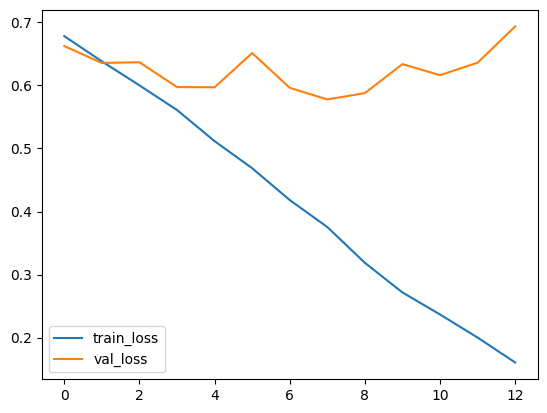

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

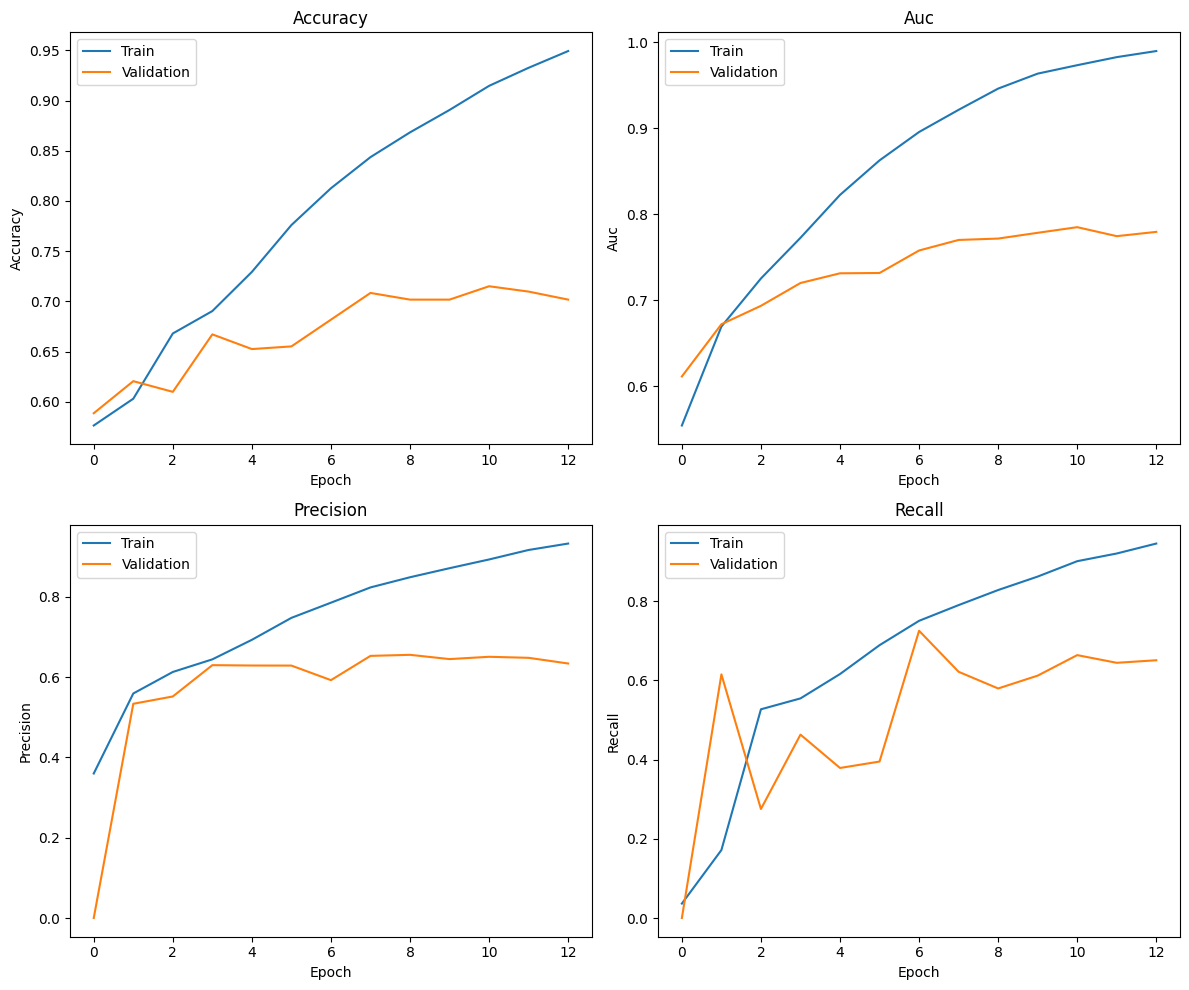

In [16]:
import matplotlib.pyplot as plt

# Assume 'history' is the returned object from model.fit()
# Example: history = model.fit(...)

# Plot training & validation accuracy, AUC, precision, and recall
metrics = ['accuracy', 'auc', 'precision', 'recall']

plt.figure(figsize=(12, 10))
for idx, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, idx)
    plt.plot(history.history[metric], label='Train')
    plt.plot(history.history['val_' + metric], label='Validation')
    plt.title(metric.capitalize())
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()

24/24 [==============================] - 0s 5ms/step


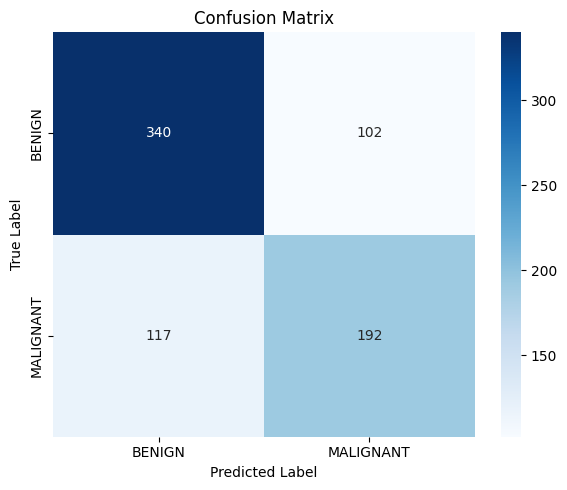

Error: plotly is required to log interactive plots, install with: `pip install plotly` or convert the plot to an image with `wandb.Image(plt)`

<Figure size 640x480 with 0 Axes>

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Collect all validation data and labels
val_images = []
val_labels = []

for batch in val_ds:
    imgs, labels = batch
    val_images.append(imgs.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# 2. Model predictions on validation images
y_prob = model.predict(val_images)

# 3. Convert probabilities to predicted labels
if y_prob.shape[-1] == 1:  # Binary
    y_pred = (y_prob > 0.5).astype(int).flatten()
    y_true = val_labels.flatten()
    labels = ["BENIGN", "MALIGNANT"]
else:  # Multiclass
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(val_labels, axis=1)
    # Define your own labels if >2 classes
    labels = [f"Class {i}" for i in range(y_prob.shape[-1])]

# 4. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 5. Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# --- Log the confusion matrix image to Weights & Biases ---
# run.log({"confusion_matrix": plt})


In [19]:
# End the run
run.finish()

epoch/accuracy,▁▂▃▃▄▅▅▆▆▇▇██
epoch/auc,▁▃▄▅▅▆▆▇▇████
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▅▄▄▃▃▂▂▁
epoch/precision,▁▃▄▄▅▆▆▇▇▇███
epoch/recall,▁▂▅▅▅▆▆▇▇▇███
epoch/val_accuracy,▁▃▂▅▅▅▆█▇▇██▇
epoch/val_auc,▁▃▄▅▆▆▇▇▇████
epoch/val_loss,▆▄▅▂▂▅▂▁▂▄▃▅█
epoch/val_precision,▁▇▇███▇██████


In [18]:
# Save in the new Keras format
model.save("./models/baseline-part-1-cnn-2-conv-layers.keras")

- **1. Strong Training Performance**

* **Training accuracy (0.95), AUC (0.99), precision (0.93), recall (0.94), and loss (0.16) are all excellent.**

  * The model nearly perfectly fits the training data.

- **2. Limited Generalization on Validation**

* **Validation accuracy (0.70), AUC (0.78), precision (0.63), recall (0.65), and loss (0.69) are much lower.**

  * The drop from training to validation is substantial, especially in AUC and precision.
  * **Validation loss (0.69)** is close to the value for a random classifier in binary cross-entropy (\~0.69), suggesting limited separation.

- **3. Possible Overfitting**

* **Large gap between train and validation metrics** (accuracy, AUC, precision, recall) implies the model is overfitting.

  * The model learns the training data extremely well, but fails to generalize as effectively to unseen data.
  * Overfitting is also suggested by the pattern in the metric bars: train metrics ramp up rapidly and flatten, while validation metrics plateau much lower.

- **4. Moderate but Insufficient Validation Performance**

* **Validation AUC (0.78)** is below the generally accepted threshold (AUC > 0.80–0.85) for medical models to be considered clinically useful.
* **Precision and recall on validation** are in the mid-0.6 range, meaning the model misses a substantial number of positives and has false positives.

- **5. Model May Be Too Simple**

* The quick, nearly perfect fit on training data but not on validation often points to either:

  * Not enough regularization,
  * Model capacity that is too high relative to dataset size,
  * Or, conversely, a model that is not complex enough to generalize (if the dataset is very complex)

- **Summary Paragraph**

The model achieves very high accuracy and AUC on the training set, indicating it can fit the training data almost perfectly. However, validation performance is much lower across all metrics—accuracy, AUC, precision, recall, and loss—suggesting significant overfitting. The validation AUC (0.78) and accuracy (0.70) fall short of the thresholds typically required for clinical relevance in medical imaging tasks, and the validation loss remains close to that of a random classifier. This implies that while the model learns the training data well, it does not generalize sufficiently to new data, and further improvements are needed through regularization, model tuning, or data augmentation to reduce overfitting and achieve clinically meaningful performance.

### Part 2: CNN with 2 Conv Layers + Dropout
  To mitigate overfitting and improve the model’s ability to generalize, a Dropout layer is added after the dense layer. Dropout randomly deactivates a proportion of neurons during training, preventing the network from relying too heavily on specific features.

We use Weights and Biases Sweeps to automate hyperparameter search and model optimization. https://docs.wandb.ai/guides/sweeps/

In [ ]:
import wandb
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import AUTOTUNE
import os

# Build a CNN model with 2 convolutional layers and dropout
def build_model(input_shape, filters=32, kernel_size=3, dropout=0.3):
    model = models.Sequential([
        layers.Conv2D(filters, kernel_size, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2),
        layers.Conv2D(filters*2, kernel_size, activation='relu'),
        layers.MaxPooling2D(2),
        layers.Flatten(),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Main training function
def train():
    # Initialize wandb
    wandb.init(project="baseline_part_2_cnn_2_conv_layers_dropout")
    config = wandb.config

    # Data loading
    metadata = pd.read_csv("../data/processed/cbis_ddsm_metadata_full.csv")
    # Split
    train_meta, val_meta = train_test_split(metadata, test_size=0.2, stratify=metadata['label'], random_state=42)
    train_meta.to_csv("../temporary/train_split.csv", index=False)
    val_meta.to_csv("../temporary/val_split.csv", index=False)
    # Build datasets
    train_ds = build_tf_dataset(metadata_csv="../temporary/train_split.csv", batch_size=8)
    val_ds = build_tf_dataset(metadata_csv="../temporary/val_split.csv", batch_size=8)
    train_ds = train_ds.map(lambda x, y: (x, y["classification"])).prefetch(AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (x, y["classification"])).prefetch(AUTOTUNE)

    # Build the model with sweep config values
    model = build_model(
        input_shape=(224, 224, 1),           # <-- replace with your true input shape
        filters=config.filters,
        kernel_size=config.kernel_size,
        dropout=config.dropout
    )

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc"),
                 tf.keras.metrics.Precision(name="precision"),
                 tf.keras.metrics.Recall(name="recall")]
    )

    # Train
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=[
            wandb.keras.WandbMetricsLogger(),
            EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)
        ],
        verbose=2
    )

# Sweep configuration (as a Python dict, or save as sweep.yaml)
sweep_config = {
    "method": "bayes",  # or "random", "grid"
    "metric": {"name": "val_auc", "goal": "maximize"},
    "parameters": {
        "learning_rate": {"min": 1e-5, "max": 1e-3},
        "batch_size": {"values": [8, 16, 32]},
        "filters": {"values": [16, 32, 64]},
        "kernel_size": {"values": [3, 5]},
        "dropout": {"min": 0.0, "max": 0.5},
        "epochs": {"value": 20}
    }
}

# Launch the sweep
import wandb

sweep_id = wandb.sweep(sweep_config, project="baseline_part_2_cnn_2_conv_layers_dropout")
wandb.agent(sweep_id, function=train)


### Analyze the results of the hyperparameter sweep

Download all runs from the project

In [8]:
import wandb
import pandas as pd

# 1. Initialize API and get all runs for the project
PROJECT = "tkshfj-bsc-computer-science-university-of-london/MMG-notebooks"
api = wandb.Api()
runs = api.runs(PROJECT)

print(f"Found {len(runs)} runs.")

# 2. Build DataFrame with config and summary metrics
records = []
for run in runs:
    row = dict(run.config)
    for k, v in run.summary.items():
        if not k.startswith('_'):
            row[k] = v
    row['run_id'] = run.id
    row['run_name'] = run.name
    records.append(row)

df = pd.DataFrame(records)
# print(df.shape)
df

Found 82 runs.


,epochs,dropout,filters,batch_size,kernel_size,learning_rate,epoch/accuracy,epoch/auc,epoch/epoch,epoch/learning_rate,...,epoch/val_accuracy,epoch/val_auc,epoch/val_loss,epoch/val_precision,epoch/val_recall,run_id,run_name,zoom,rotation,translation
0,20,0.333958,64,32,5,0.000040,0.769667,0.848177,19,0.000040,...,0.683089,0.730330,0.606858,0.647303,0.504854,h6zl7pfq,rural-sweep-1,NaN,NaN,NaN
1,20,0.450683,32,32,3,0.000940,0.862333,0.937513,7,0.000940,...,0.675100,0.725153,0.686992,0.629482,0.511327,luoi4yy0,rural-sweep-2,NaN,NaN,NaN
2,20,0.187177,32,8,5,0.000616,0.927000,0.975493,7,0.000616,...,0.677763,0.733189,0.824701,0.625468,0.540453,r0ilv59w,hopeful-sweep-3,NaN,NaN,NaN
3,20,0.414729,16,32,5,0.000563,0.807333,0.889933,9,0.000563,...,0.669774,0.732146,0.647329,0.626556,0.488673,ahf8fx73,fast-sweep-4,NaN,NaN,NaN
4,20,0.362670,16,32,5,0.000765,0.812000,0.897814,8,0.000765,...,0.671105,0.713955,0.699310,0.596875,0.618123,lvrd4eo0,comfy-sweep-5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,20,0.372657,32,8,3,0.000413,0.614333,0.616048,8,0.000413,...,0.567244,0.565226,0.681682,0.433333,0.168285,yb4a1wil,swift-sweep-56,0.173033,0.094609,0.091088
78,20,0.131336,16,32,5,0.000304,0.626000,0.658534,19,0.000304,...,0.612517,0.677093,0.637602,0.569231,0.239482,ja2y5ok9,apricot-sweep-57,0.017703,0.030322,0.098680
79,20,0.469011,16,32,3,0.000250,0.615667,0.630127,9,0.000250,...,0.563249,0.608898,0.672627,0.404040,0.129450,y5ezvotw,happy-sweep-58,0.004499,0.039126,0.139478
80,20,0.066601,16,8,3,0.000854,0.609000,0.591897,18,0.000854,...,0.539281,0.551740,0.714780,0.445104,0.485437,2y7pik9h,leafy-sweep-59,0.052411,0.018349,0.189488


Average duration: 50.38 minutes per run
Typical sweep (50 runs): 41.99 hours (sequential)


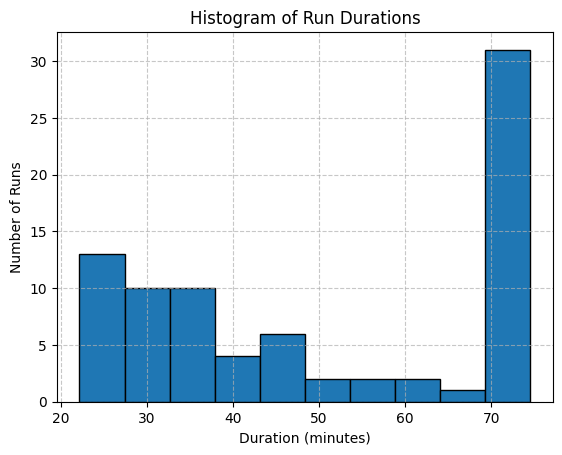

In [9]:
import wandb
import numpy as np
import matplotlib.pyplot as plt

api = wandb.Api()
project = "tkshfj-bsc-computer-science-university-of-london/MMG-notebooks"
runs = api.runs(project)

durations = [run.summary.get('_runtime', 0) for run in runs if run.state == "finished"]
# _runtime is in seconds
if durations:
    durations_min = np.array(durations) / 60  # convert to minutes
    avg_seconds = np.mean(durations)
    print(f"Average duration: {avg_seconds/60:.2f} minutes per run")
    print(f"Typical sweep (50 runs): {avg_seconds*50/3600:.2f} hours (sequential)")

    # Plot histogram
    plt.hist(durations_min, bins=10, edgecolor='black')
    plt.title("Histogram of Run Durations")
    plt.xlabel("Duration (minutes)")
    plt.ylabel("Number of Runs")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No finished runs found.")

Find the Best Run by Metric (e.g., epoch/val_auc)

In [7]:
# 3. Find best run by 'epoch/val_auc'
if 'epoch/val_auc' in df.columns:
    best_idx = df['epoch/val_auc'].idxmax()
    best_run = df.iloc[best_idx]
    print("Best run name:", best_run['run_name'])
    print("Best run ID:", best_run['run_id'])
    print("Best run val_auc:", best_run['epoch/val_auc'])

    # 4. Build URL
    url = f"https://wandb.ai/{PROJECT}/runs/{best_run['run_id']}"
    print("Best run URL:", url)
else:
    print("epoch/val_auc not found in DataFrame columns:", df.columns)

Best run name: misunderstood-sweep-13
Best run ID: rslor9qo
Best run val_auc: 0.7458154559135437
Best run URL: https://wandb.ai/tkshfj-bsc-computer-science-university-of-london/MMG-notebooks/runs/rslor9qo


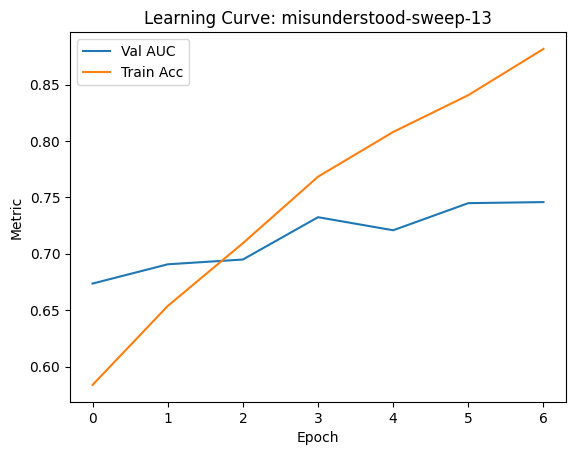

In [8]:
import matplotlib.pyplot as plt
# Get the best run's history for learning curve
run = api.run(f"{PROJECT}/runs/{best_run['run_id']}")
history = run.history()

plt.figure()
plt.plot(history['epoch/epoch'], history['epoch/val_auc'], label='Val AUC')
plt.plot(history['epoch/epoch'], history['epoch/accuracy'], label='Train Acc')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title(f"Learning Curve: {best_run['run_name']}")
plt.legend()
plt.show()

In [9]:
print(history.columns)

Index(['_timestamp', '_runtime', 'epoch/val_precision', 'epoch/recall',
       'epoch/val_recall', '_step', 'epoch/val_loss', 'epoch/val_auc',
       'epoch/loss', 'epoch/epoch', 'epoch/precision', 'epoch/auc',
       'epoch/accuracy', 'epoch/val_accuracy', 'epoch/learning_rate'],
      dtype='object')


#### Find the Best Runs

In [10]:
best_run = df.sort_values("epoch/val_auc", ascending=False).iloc[0]
print("Best run config:", best_run)

Best run config: epochs                                     20
dropout                              0.286152
filters                                    64
batch_size                                 16
kernel_size                                 5
learning_rate                        0.000536
epoch/accuracy                       0.881667
epoch/auc                            0.950729
epoch/epoch                                 6
epoch/learning_rate                  0.000536
epoch/loss                           0.286677
epoch/precision                      0.870479
epoch/recall                         0.837379
epoch/val_accuracy                   0.695073
epoch/val_auc                        0.745815
epoch/val_loss                       0.741272
epoch/val_precision                   0.63986
epoch/val_recall                     0.592233
run_id                               rslor9qo
run_name               misunderstood-sweep-13
Name: 12, dtype: object


In [13]:
best_idx = df['epoch/val_auc'].idxmax()
best_run = df.iloc[best_idx]
print(best_run)

epochs                                     20
dropout                              0.286152
filters                                    64
batch_size                                 16
kernel_size                                 5
learning_rate                        0.000536
epoch/accuracy                       0.881667
epoch/auc                            0.950729
epoch/epoch                                 6
epoch/learning_rate                  0.000536
epoch/loss                           0.286677
epoch/precision                      0.870479
epoch/recall                         0.837379
epoch/val_accuracy                   0.695073
epoch/val_auc                        0.745815
epoch/val_loss                       0.741272
epoch/val_precision                   0.63986
epoch/val_recall                     0.592233
run_id                               rslor9qo
run_name               misunderstood-sweep-13
Name: 12, dtype: object


#### Analyze Hyperparameter Trends

#### Automated Result Plotting: Hyperparameter vs. Metric

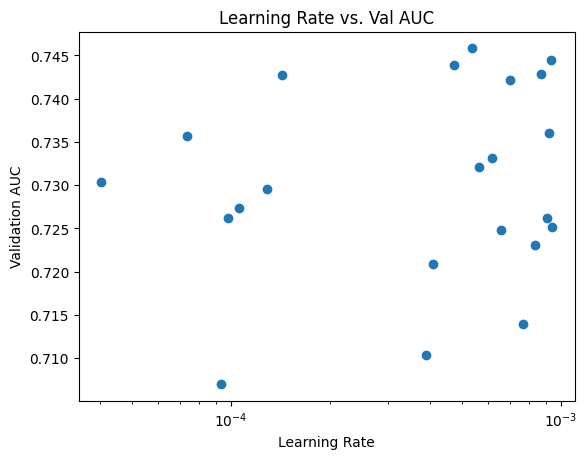

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df['epoch/learning_rate'], df['epoch/val_auc'])
plt.xlabel("Learning Rate")
plt.ylabel("Validation AUC")
plt.title("Learning Rate vs. Val AUC")
plt.xscale("log")
plt.show()


#### Parallel Coordinates Plot

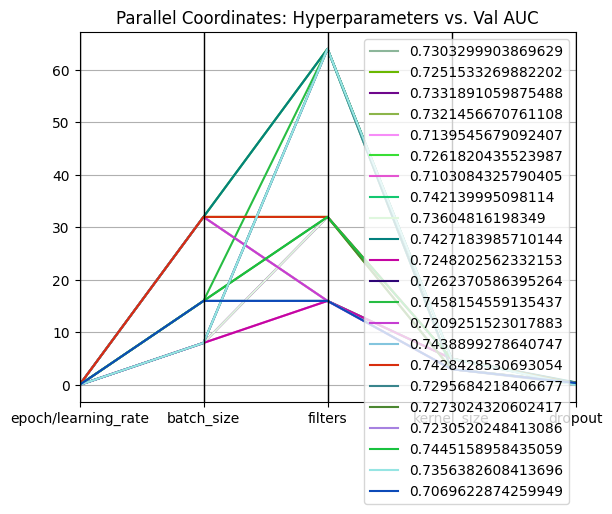

In [16]:
import pandas as pd
from pandas.plotting import parallel_coordinates

params = ['epoch/learning_rate', 'batch_size', 'filters', 'kernel_size', 'dropout']
parallel_coordinates(df[params + ['epoch/val_auc']], class_column='epoch/val_auc')
plt.title("Parallel Coordinates: Hyperparameters vs. Val AUC")
plt.show()

#### Learning Curves (Best/All Runs)

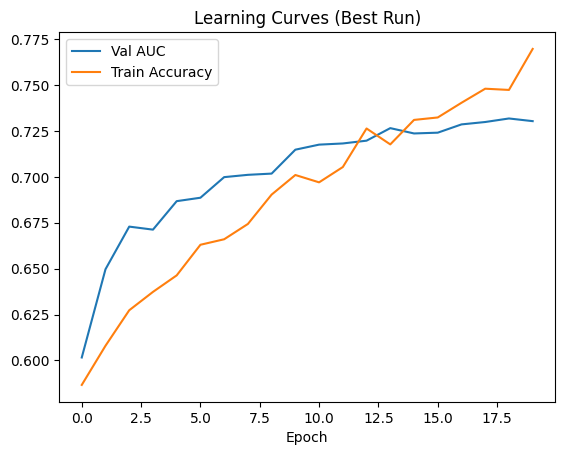

In [17]:
# Example: download and plot learning curves for the best run
run = api.run("tkshfj-bsc-computer-science-university-of-london/MMG-notebooks/h6zl7pfq")
history = run.history()
plt.plot(history['epoch/epoch'], history['epoch/val_auc'], label='Val AUC')
plt.plot(history['epoch/epoch'], history['epoch/accuracy'], label='Train Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title("Learning Curves (Best Run)")
plt.show()

### Part 3: CNN with 2 Conv Layers + Data Augmentation
  Building on Part 2, data augmentation techniques are introduced during the training phase. Methods such as random rotations, translations, zooms, and horizontal flips are applied to the input images, artificially increasing the diversity of the training set and further reducing the risk of overfitting.

We apply data augmentation to your data pipeline to enhance the model's robustness and generalization capabilities. This involves applying transformations such as random rotations, shifts, zooms, and flips to the training images, which helps the model learn invariant features and improves its performance on unseen data.

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Example of setting up data augmentation for training data
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # For validation/test, only rescale
# val_datagen = ImageDataGenerator(rescale=1./255)

# # Example:
# # train_generator = train_datagen.flow_from_directory(
# #     'data/train',
# #     target_size=(224, 224),
# #     batch_size=32,
# #     class_mode='categorical',  # or 'binary'
# #     color_mode='grayscale',    # if images are grayscale
# # )

# # Use the same model as Part 2 (with dropout)
# model = build_shallow_cnn_dropout(input_shape=INPUT_SHAPE, num_classes=2)
